In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
import imageio
import os

from tqdm import tqdm

# 1. Implement Schelling's Model

In [2]:
def initialize_world(n):
    '''
    0  is for free spaces, 1 is for white householders, -1 is for black householders
    '''
    
    world = np.zeros(n * n)
    size = int(n * n / 4)
    
    idx_white = np.random.choice(n * n, size, replace=False)
    world[idx_white] = 1
    
    left_idx = list(set(range(n * n)) - set(idx_white))
    idx_black = np.random.choice(left_idx, size, replace=False)
    world[idx_black] = -1
    
    return world.reshape(n, n)

In [3]:
n = 100
world = initialize_world(n)

In [4]:
len(np.where(world == 0)[0]), len(np.where(world == 1)[0]), len(np.where(world == -1)[0])

(5000, 2500, 2500)

In [5]:
n ** 2 // 2

5000

# 2. Plot Initial World

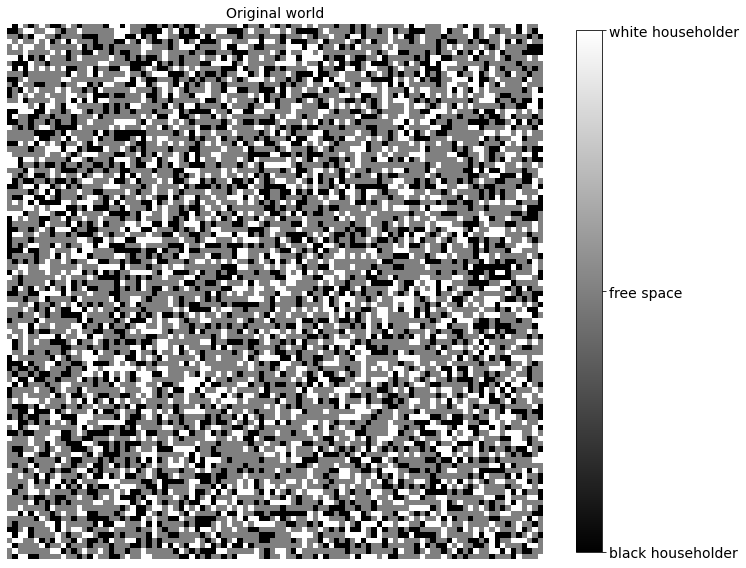

In [6]:
plt.figure(figsize=(12, 12))
plt.imshow(world, cm.binary_r)

cbar = plt.colorbar(shrink=.8, aspect=20)
cbar.set_ticks([1, 0, -1])
cbar.ax.set_yticklabels(['white householder', 'free space', 'black householder'], fontsize=14)

plt.axis('off')
plt.title(f'Original world', fontsize=14)
plt.show()

# 3. Run Mutiple Steps of Evolution for Some $r = 0.375$ (for Instance)

In [7]:
def check_happiness(neighbourhood, color, ratio):
    count = -1
    
    for i in range(len(neighbourhood)):
        if neighbourhood[i] == color:
            count += 1
    
    return count / (len(neighbourhood) - 1) >= ratio

In [8]:
def find_unhappy_householders(world):
    idx_unhappy = []
    n = world.shape[0]
    
    for i in range(n):
        for j in range(n):
            if world[i, j] != 0:
#                 i_min, i_max = max(i - 1, 0), min(i + 2, n)
#                 j_min, j_max = max(j - 1, 0), min(j + 2, n)
#                 neighbourhood = world[i_min:i_max, j_min:j_max].reshape(-1)
                
                neighbourhood = []
                for sur_i in range(i - 1, i + 2):
                    actual_sur_i = n * int(sur_i == -1) + sur_i - n * int(sur_i == n)
                    for sur_j in range(j - 1, j + 2):
                        actual_sur_j = n * int(sur_j == -1) + sur_j - n * int(sur_j == n)
                        neighbourhood.append(world[actual_sur_i, actual_sur_j])
                        
                if not check_happiness(neighbourhood, world[i, j], r):
                    idx_unhappy.append((i, j))
    
    return idx_unhappy

In [9]:
def run_modeling(world, r, n_iterations):
    world_snapshots = [world]
    unhappy_history = []
    
    for _ in range(n_iterations):
        world = copy.copy(world_snapshots[-1])

        # find unhappy householders
        idx_unhappy = find_unhappy_householders(world)
        unhappy_history.append(len(idx_unhappy))
        
        # reserve places for unhappy householders
        idx_free = np.vstack(np.where(world == 0)).T
        idx_reserved = np.random.permutation(idx_free)[:len(idx_unhappy)]
        idx_unhappy = np.random.permutation(idx_unhappy)[:len(idx_reserved)]

        # randomly distribute unhappy householders on reserved places
        for k, (i, j) in enumerate(idx_unhappy):
            world[tuple(idx_reserved[k])] = world[i, j]
            world[i, j] = 0
        
        world_snapshots.append(world)
    
    # find unhappy householders after modeling
    world = copy.copy(world_snapshots[-1])
    idx_unhappy = find_unhappy_householders(world)
    unhappy_history.append(len(idx_unhappy))
    
    return world_snapshots, unhappy_history

In [10]:
n_iterations = 100
rr = np.array(range(9)) / 8
r = rr[3]

In [11]:
world_snapshots, unhappy_history = run_modeling(world, r, n_iterations)

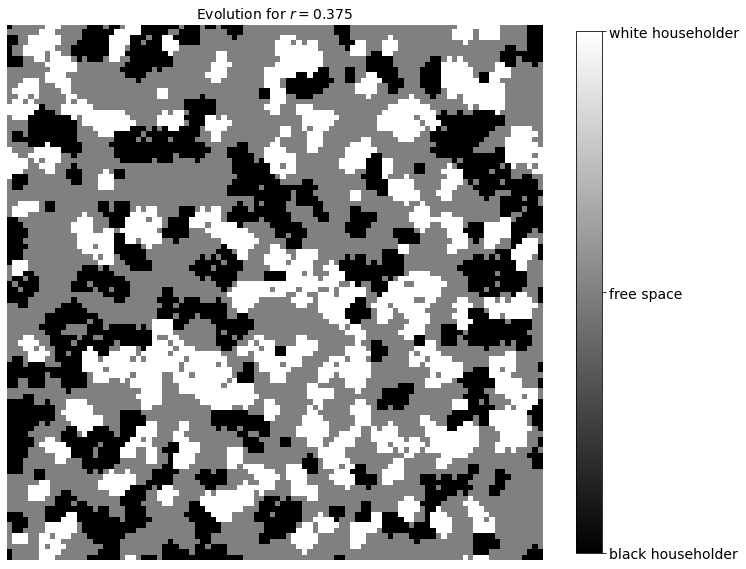

In [12]:
plt.figure(figsize=(12, 12))
plt.imshow(world_snapshots[-1], cm.binary_r)

cbar = plt.colorbar(shrink=.8, aspect=20)
cbar.set_ticks([1, 0, -1])
cbar.ax.set_yticklabels(['white householder', 'free space', 'black householder'], fontsize=14)

plt.axis('off')
plt.title(f'Evolution for $r = {r}$', fontsize=14)
plt.show()

In [13]:
len(np.where(world == 0)[0]), len(np.where(world == 1)[0]), len(np.where(world == -1)[0])

(5000, 2500, 2500)

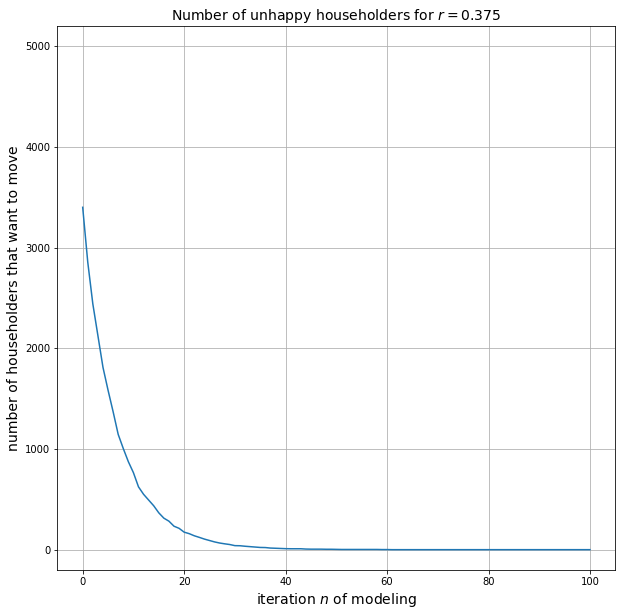

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(list(range(n_iterations + 1)), unhappy_history)

plt.title(f'Number of unhappy householders for $r = {r}$', fontsize=14)
plt.ylim(-200, n ** 2 // 2 + 200)

plt.xlabel('iteration $n$ of modeling', fontsize=14)
plt.ylabel('number of householders that want to move', fontsize=14)
plt.grid()
plt.show()

## Joint Plot of World Evolution and Number of Unhappy Householders

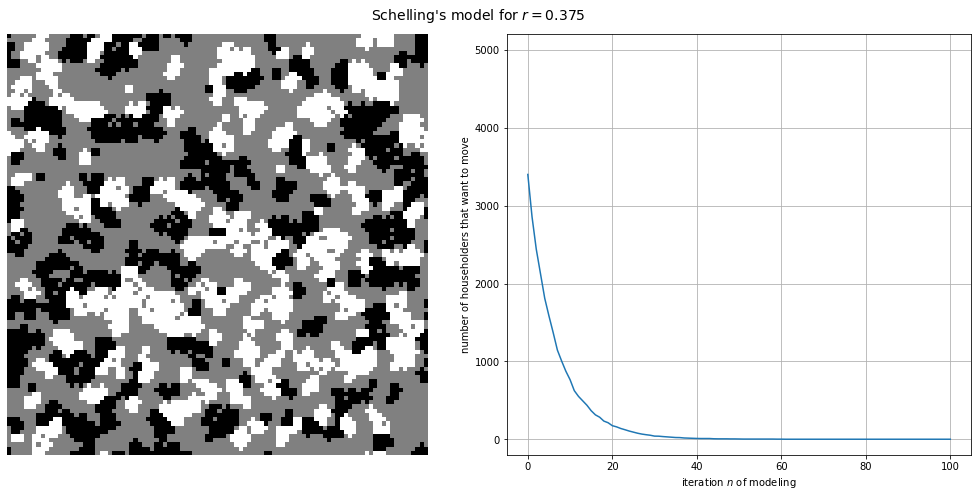

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), frameon=False)
step = 100

cur_world_snapshots = world_snapshots[step]
ax[0].imshow(cur_world_snapshots, cm.binary_r)
ax[0].axis('off')

cur_range = list(range(step + 1))
cur_unhappy_history = unhappy_history[:step + 1]
ax[1].plot(cur_range, cur_unhappy_history)
ax[1].set_xlabel('iteration $n$ of modeling', fontsize=10)
ax[1].set_ylabel('number of householders that want to move', fontsize=10)

ax[1].grid()
ax[1].set_xlim(-5, 105)
ax[1].set_ylim(-200, n ** 2 // 2 + 200)

plt.suptitle(f'Schelling\'s model for $r = {r}$', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.925)
plt.show()

# 4. Modeling for Every $r$ in `np.array(range(9)) / 8`

In [16]:
world_snapshots_r = []
unhappy_history_r = []

for r in tqdm(rr):
    world_snapshots, unhappy_history = run_modeling(world, r, n_iterations)
    
    world_snapshots_r.append(world_snapshots)
    unhappy_history_r.append(unhappy_history)

100%|██████████| 9/9 [00:59<00:00,  6.59s/it]


In [17]:
colors = cm.PuBu_r(np.linspace(0, 1, len(rr)))
labels = ['0'] + [str(i) + '/8' for i in range(1, 8)] + ['1']

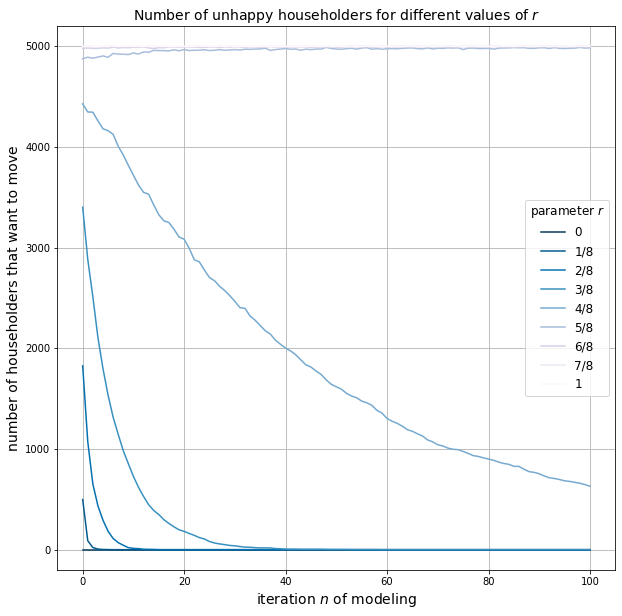

In [18]:
plt.figure(figsize=(10, 10))

for i in range(len(rr)):
    plt.plot(list(range(n_iterations + 1)), unhappy_history_r[i], color=colors[i])

plt.title(f'Number of unhappy householders for different values of $r$', fontsize=14)
plt.ylim(-200, n ** 2 // 2 + 200)

plt.xlabel('iteration $n$ of modeling', fontsize=14)
plt.ylabel('number of householders that want to move', fontsize=14)

legend = plt.legend(labels, title='parameter $r$', fontsize=12)
legend.get_title().set_fontsize('12')

plt.grid()
plt.show()

In [19]:
for k in tqdm(range(len(rr))):
    r = rr[k]
    
    folder = f'./schelling-evolution-{r}/'
    if not os.path.exists(folder):
        os.mkdir(folder)
        
    world_snapshots = world_snapshots_r[k]
    unhappy_history = unhappy_history_r[k]

    for i in range(n_iterations + 1):
        fig, ax = plt.subplots(1, 2, figsize=(14, 7), frameon=False)

        cur_world_snapshots = world_snapshots[i]
        ax[0].imshow(cur_world_snapshots, cm.binary_r)
        ax[0].axis('off')

        cur_range = list(range(i + 1))
        cur_unhappy_history = unhappy_history[:i + 1]
        ax[1].plot(cur_range, cur_unhappy_history)
        ax[1].set_xlabel('iteration $n$ of modeling', fontsize=10)
        ax[1].set_ylabel('number of householders that want to move', fontsize=10)

        ax[1].grid()
        ax[1].set_xlim(-5, 105)
        ax[1].set_ylim(-200, n ** 2 // 2 + 200)
        
        plt.suptitle(f'Schelling\'s model for $r = {r}$', fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.925)

        plt.savefig(folder + f'step-{i}.jpg', bbox_inches='tight')
        plt.close('all')
    
    filenames = list(filename for filename in os.listdir(folder) if filename.endswith('jpg'))
    filenames = sorted(filenames, key=lambda x: int(os.path.splitext(x)[0].split('-')[-1]))
    
    images = []
    for filename in filenames:
        images.append(imageio.imread(folder + filename))

    imageio.mimsave(folder + 'schelling-motion.gif', images)

100%|██████████| 9/9 [05:42<00:00, 38.09s/it]


In [20]:
from IPython.display import HTML
HTML('<img src="./schelling-evolution-0.375/schelling-motion.gif">')